In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Download cats_vs_dogs datasets and load it to training batches
#This data is corrupted
# PATH_TO_DOWNLOAD = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

# dataset_path = tf.keras.utils.get_file(origin = PATH_TO_DOWNLOAD, fname="cats_vs_dogs", extract=True,untar=True)
# !unzip /root/.keras/datasets/cats_vs_dogs.tar.gz

In [ ]:
!cd '/content/drive/MyDrive/Colab Notebooks/speech_recognition/tensorflow-book/'
!pwd

In [ ]:
import pathlib
import os

dataset_dir = '/content/drive/MyDrive/Colab Notebooks/speech_recognition/tensorflow-book/train.zip'
dataset_dir = pathlib.Path(dataset_dir)


#Building a dataset object from directories
batch_size = 16
image_height = 224
image_width = 224
seed = 123

#Specific to this dataset. There are corrupted images need to be removed
# def remove_invalid_image(path):
#   for image in os.listdir(path):
#       file = os.path.join(path,image)
#       if not imghdr.what(file):
#         os.remove(file)
  
#Remove a none jpg file to avoid Error when train the model
# for file in os.listdir(os.path.join(dataset_dir, 'Cat')):
#   if not file.endswith('.jpg'):
#     path = os.path.join(dataset_dir, 'Cat', file)
#     os.remove(path)
# for file in os.listdir(os.path.join(dataset_dir, 'Dog')):
#   if not file.endswith('.jpg'):
#     path = os.path.join(dataset_dir, 'Dog', file)
#     os.remove(path)


remove_invalid_image(os.path.join(dataset_dir, 'Cat'))
remove_invalid_image(os.path.join(dataset_dir, 'Dog'))

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='training',
    batch_size = batch_size,
    seed=seed,
    image_size=(image_height, image_width),
)

print(train_ds.class_names)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='validation',
    batch_size = batch_size,
    seed=seed,
    image_size=(image_height, image_width),
)


Found 24962 files belonging to 2 classes.
Using 19970 files for training.
['Cat', 'Dog']
Found 24962 files belonging to 2 classes.
Using 4992 files for validation.


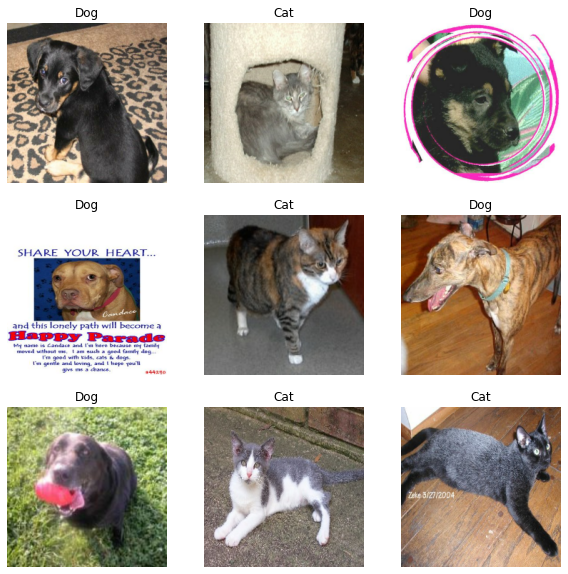

In [ ]:
#Visualize the images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title('Cat' if labels[i].numpy() == 0 else 'Dog')
    plt.axis("off")


In [ ]:
#Process the data
#1. dimension of each image varies 
#2. 0 is cat, 1 is dog
#3. format is uint8

#Configure dataset for performance

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

#Just a sample how to use keras Rescaling layer. We'll use it while building the model
normalization_layer = tf.keras.layers.Rescaling(1. / 255)

normalized_train_ds = train_ds.map(lambda x,y : (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_ds))

first_image = image_batch[0]

#Just want to look at the value range
print(np.min(first_image), np.max(first_image))

0.0 0.8695816


In [ ]:
#Building a model
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    #Number of classes = 2 ( dog and cat)
    tf.keras.layers.Dense(2)
])

model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

# model.summary()


In [ ]:
model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs = 10
)

 801/1249 [==================>...........] - ETA: 16s - loss: 0.6637 - accuracy: 0.6033

InvalidArgumentError: ignored